# CSE2510 Bonus Assignment 
## Exploring the MNIST dataset

## 3 Introductory questions

#### Question 1:

1. GaussianNB: The training procedure is fast and simple, however, it needs large amounts of data to perform reasonably.
2. Linear Discriminant Analysis: Again, it is fast and simple to train, but it only works on the assumption that data is normally distributed. 
3. KNN: It is highly adaptable to several datasets since the distance metric can be adjusted to fit several types of data. However, it is easy to overfit due to the sensibility of outliers with the distace metric.
4. Logistic Regression: Can be used to measure the weights of the decision in each of the 2 directions. However, it cannot fit data with non-linear relationships. 
5. Support Vector Machines: It allows us to generate a classifier with a margin of separation between both classes. Due to this reason, it does not work well whenever data has higher entropy (i.e. both classes are mixed together). 
6. Decision Trees: It works with really varied types of datasets since it requires no assumptions about data. Due to this, it is also really easy to overfit since it tends to create unnecessary nodes.

#### Question 2:

1. LDA: n_components -> less likely
2. KNN: n_neighbors -> less likely, p -> no effect
3. SGDClassifier: alpha -> less-likely, eta0 -> no effect since it is later adjusted, penalty -> 'l2' leads to less overfitting, max_iter -> more-likely 
4. SVC: C -> less likely, degree -> more likely if not properly regularized
5. Decision Tree: max_depth -> more likely, min_samples_leaf -> less likely

### Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import time

import matplotlib.pyplot as plt

### Load data

In [2]:
# These are your training samples along with their labels
mnist_8x8_train = np.load("data/mnist_8x8_train.npy")
mnist_28x28_train = np.load("data/mnist_28x28_train.npy")

# The labels for 8x8 and 28x28 samples are identical
mnist_28x28_labels = np.load("data/mnist_labels.npy")

# These are unknown instances that you should classify
mnist_unknown = np.load("data/mnist_28x28_unknown.npy") # If you are using the 28x28 samples
#mnist_unknown = np.load("data/mnist_8x8_unknown.npy") # If you are using the 28x28 samples

## 4 MNIST

###  4.1 Data exploration

#### Question 3:

In [3]:
np.unique(mnist_28x28_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Question 4:

In [5]:
values, counts = np.unique(mnist_28x28_labels, return_counts = True)
values, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([395, 376, 367, 378, 388, 366, 371, 366, 366, 377]))

The first array represents the value of each class, the second represents the number of values in each class respectively. 

#### Question 5:

In [6]:
from sklearn.dummy import DummyClassifier

dummyCl = DummyClassifier(strategy='most_frequent', random_state=0)
dummyCl.fit(mnist_28x28_train, mnist_28x28_labels)
dummyCl.score(mnist_8x8_train, mnist_28x28_labels)

0.10533333333333333

Therefore, we must expect a higher accuracy than 10.5% on the training dataset. 

#### Question 6:

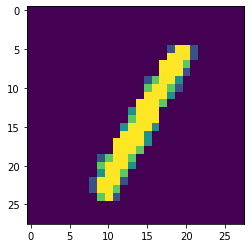

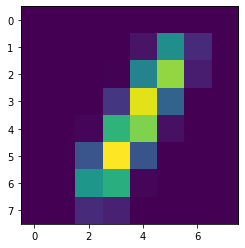

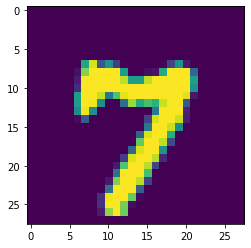

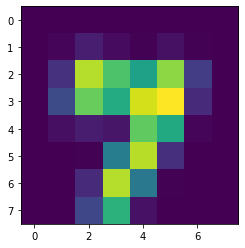

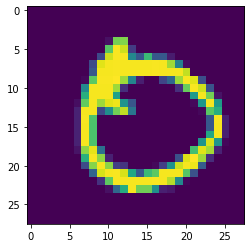

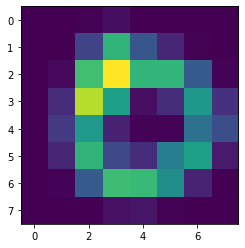

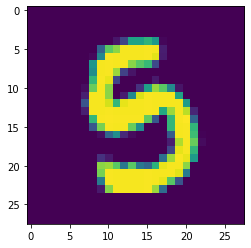

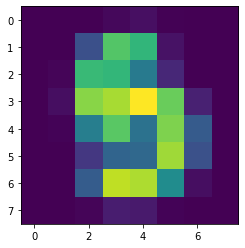

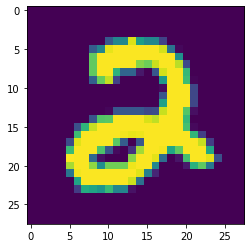

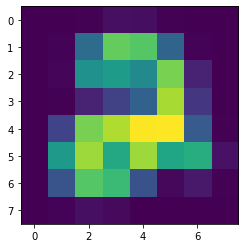

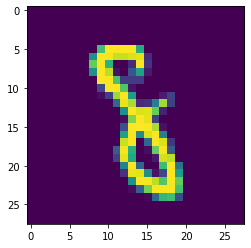

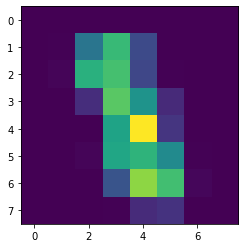

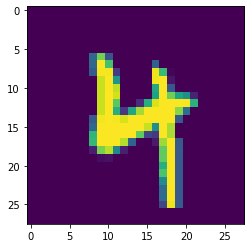

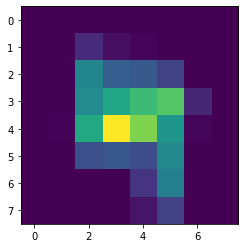

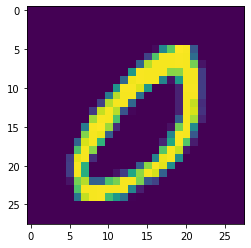

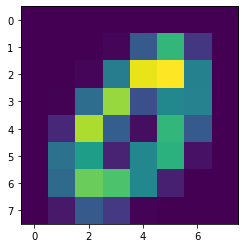

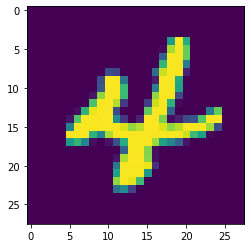

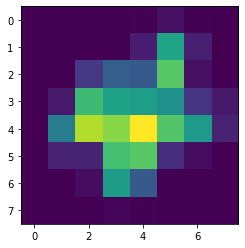

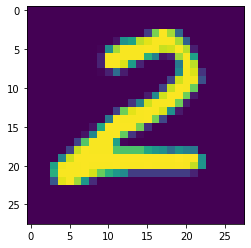

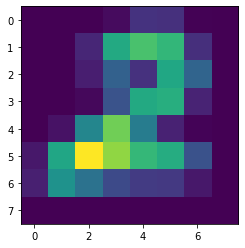

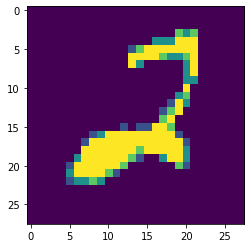

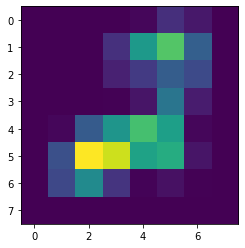

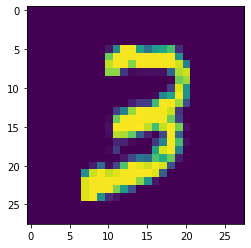

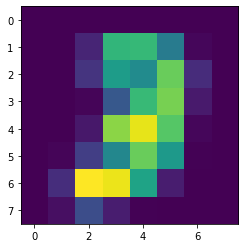

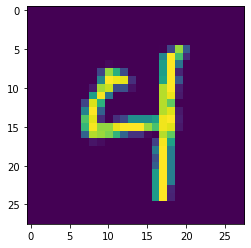

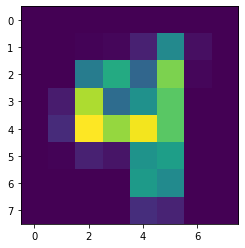

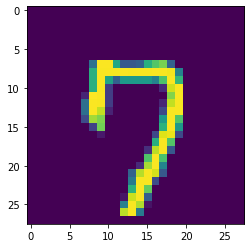

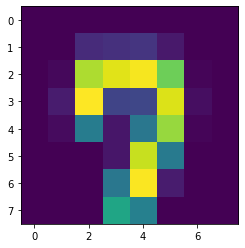

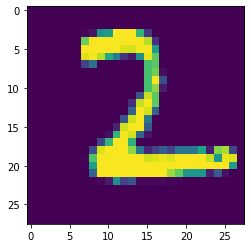

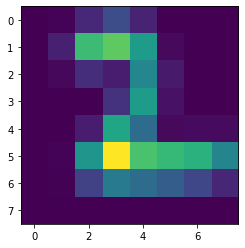

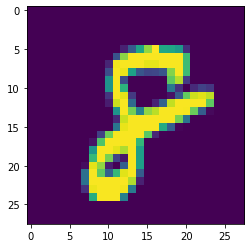

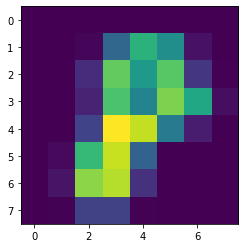

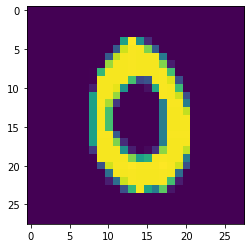

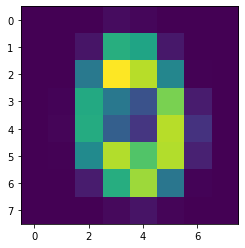

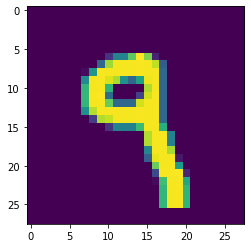

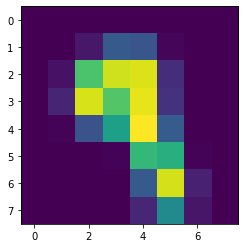

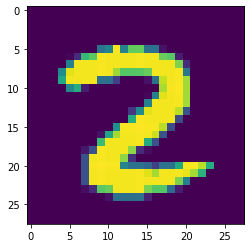

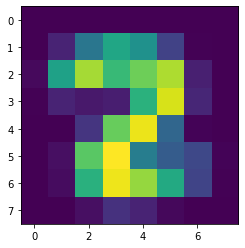

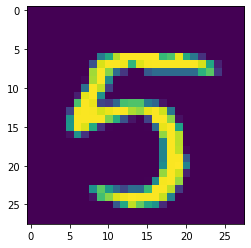

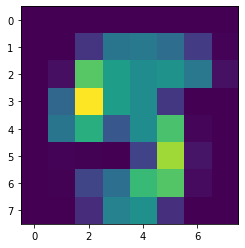

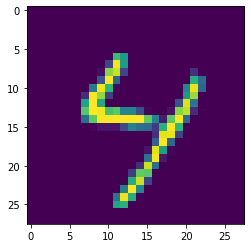

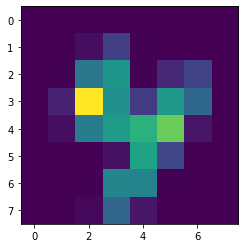

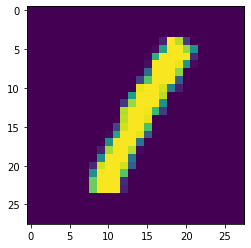

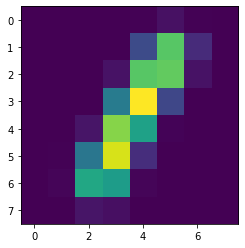

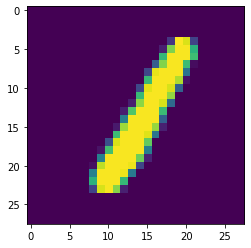

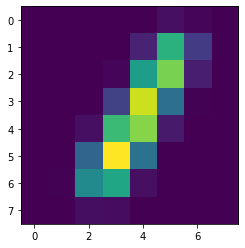

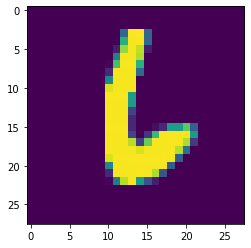

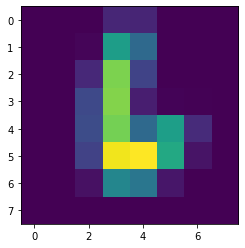

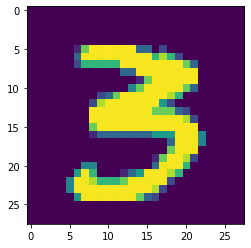

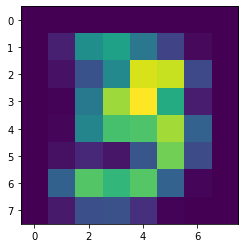

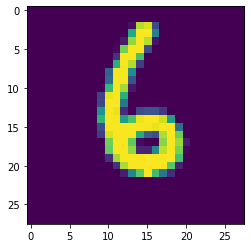

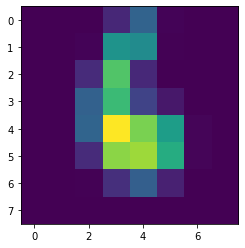

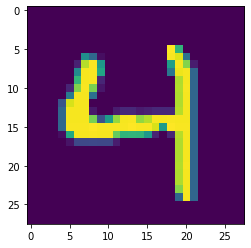

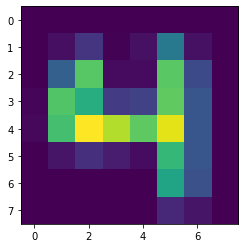

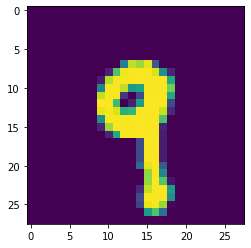

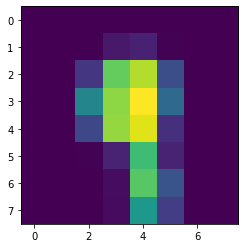

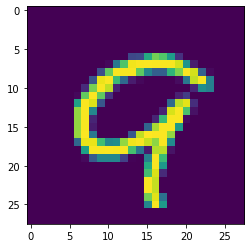

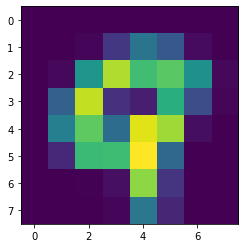

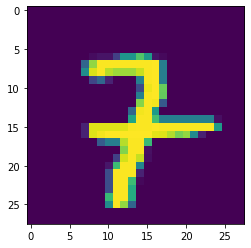

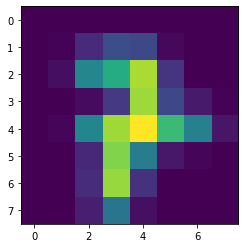

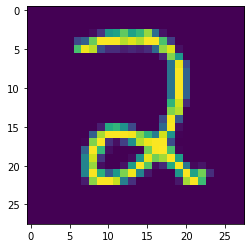

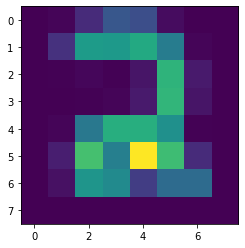

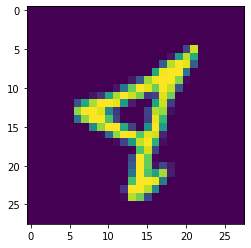

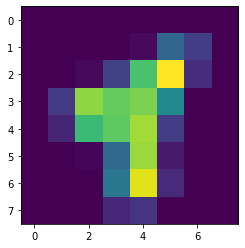

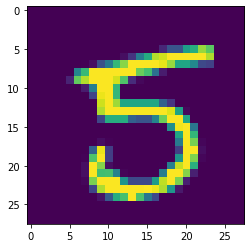

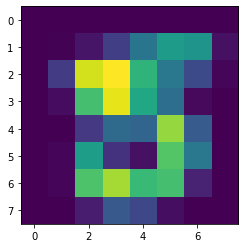

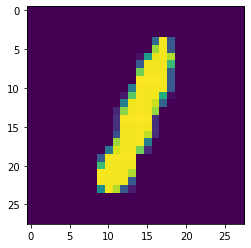

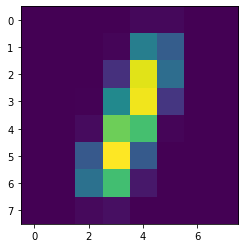

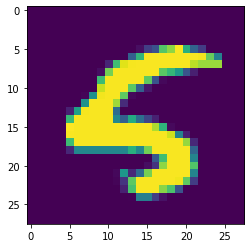

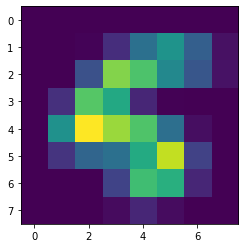

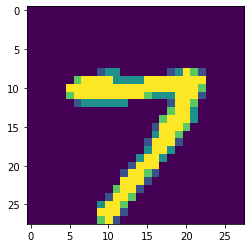

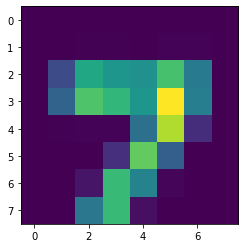

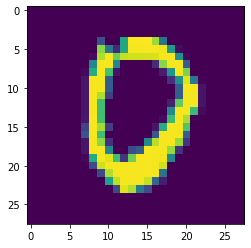

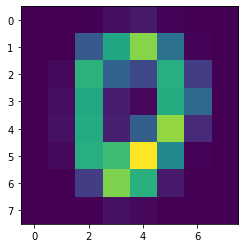

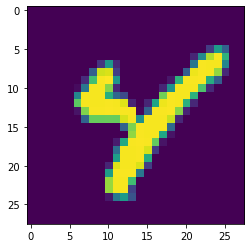

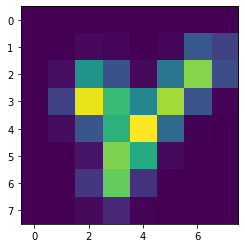

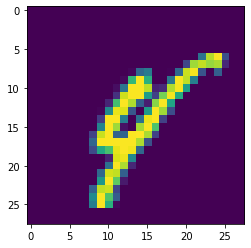

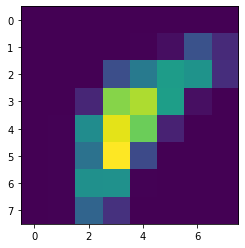

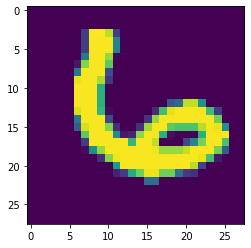

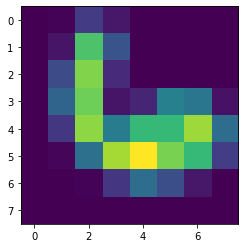

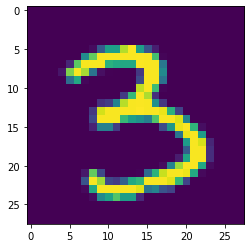

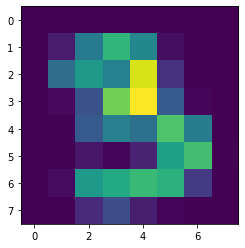

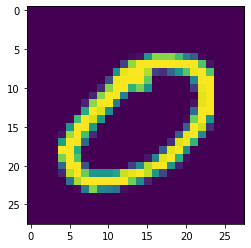

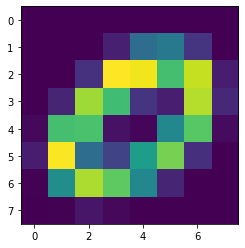

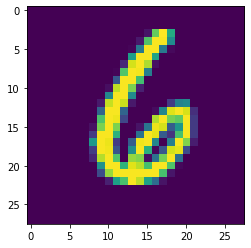

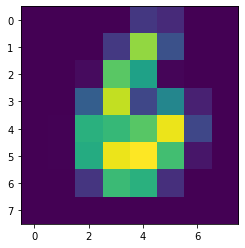

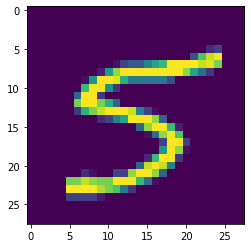

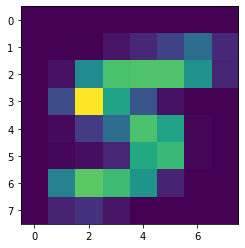

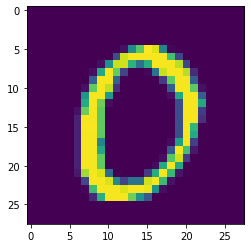

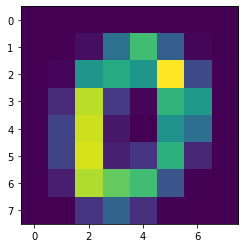

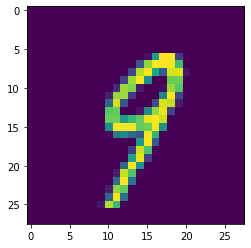

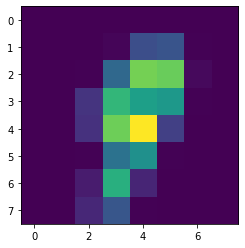

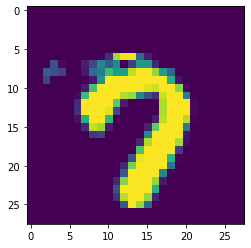

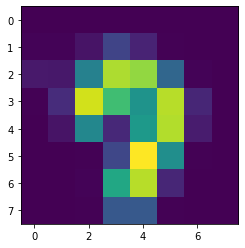

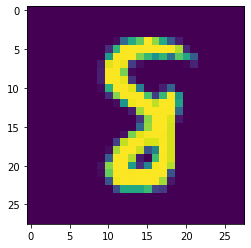

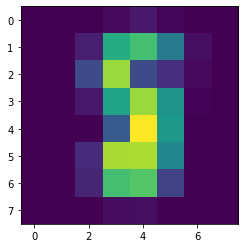

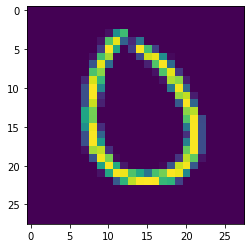

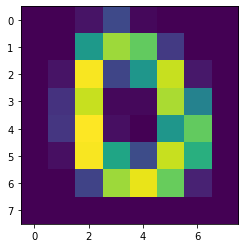

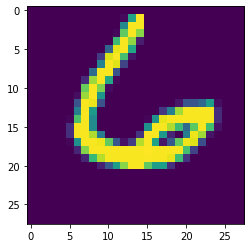

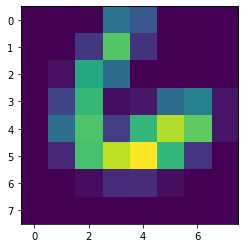

In [4]:
first50 = mnist_8x8_train[:50]
second50 = mnist_28x28_train[:50]
for i in range(50):
    plt.imshow(second50[i])  
    plt.show()
    plt.imshow(first50[i])
    plt.show()

The 28x28 dataset will yield a better classifier accuracy, given that the resolution of the digits is clearer. 

#### Question 7:

Yes, we believe that we could correctly classify all of the digits ourselves. If we use the digits in the 28 x 28 resolution, we believe that all of the digits are clearly differentiable from each other, and that a good classifier should be able to distinguish the features present on each digit. Therefore, the Bayes classifier (i.e, the optimal classifier) would yield a Bayes error of 0. 

###  4.2 Data preparation

#### Question 8:

The current dataset has no missing values (NaN), only values in the range of (0, 255), representing a pixel. Also, all of our data is continuous, since all of our values in our matrices are in digits. The only 2 preprocessing techniques that would be sensible to apply would be getting a dense matrix, as our matrices are currently sparse. However, as our data represents pixels in an image, we need to leave the matrices to preserve the features present in the digits. The other preprocessing technique, which we actual applied, was to scale all of our data in the range [0, 1] by dividing by 255.0 or by using mean unit-variance standard scaling.

#### Question 9:

In [3]:
#Examine matrix values
mnist_8x8_train_scaled = mnist_8x8_train / 255.0
#mnist_28x28_train_scaled = mnist_28x28_train / 255.0
scaler = StandardScaler()
X_reshaped = np.reshape(mnist_28x28_train, (mnist_28x28_train.shape[0], -1))
scaler.fit(X_reshaped)

mnist_28x28_train_scaled = scaler.transform(X_reshaped)
print(mnist_28x28_train_scaled[0])


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.01633211 -0.01633211
 -0.01633211 -0.02520936 -0.03243202 -0.02979463 -0.02750369 -0.03182954
 -0.04015578 -0.03407556 -0.02743523 -0.02341448 -0.02028728 -0.02396114
 -0.02133883 -0.01921893  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.01995209 -0.02306678 -0.02861906 -0.05766957
 -0.07425732 -0.09153095 -0.10065307 -0.11165694 -0.12081053 -0.13100052
 -0.13606759 -0.1342626  -0.12166562 -0.09567727 -0.07993508 -0.06180935
 -0.04902423 -0.03377007 -0.01633211 -0.01633211  0.          0.
  0.          0.          0.          0.  

Feature scaling is essential for algorithms which use distances as a metric to evaluate different features. In our case, K-Nearest-Neighbours is the only one which meets this requirement, however, other models can still benefit by this, such as the Gaussian Naive Bayes classifier. 

#### Question 10 (optional):

### 4.3 Experiments

#### Question 11:

In [4]:
#Create training and test sets for each resolution
from sklearn.model_selection import train_test_split
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(mnist_8x8_train_scaled, mnist_28x28_labels, test_size=0.33, random_state=42)
X_train_28, X_test_28, y_train_28, y_test_28 = train_test_split(mnist_28x28_train_scaled, mnist_28x28_labels, test_size=0.33, random_state=42)
#Reshape arrays
X_train_28_reshaped = np.reshape(X_train_28, (X_train_28.shape[0], -1))
X_test_28_reshaped = np.reshape(X_test_28, (X_test_28.shape[0], -1))

X_train_28.shape
X_test_28.shape

(1238, 784)

#### Question 12:

In [14]:
#GaussianNB
import time
clf = GaussianNB()
#Reshape training array
start = time.time()
clf.fit(X_train_28_reshaped, y_train_28)
stop = time.time()
inf_start =  time.time()
score = clf.score(X_test_28_reshaped, y_test_28)
inf_stop = time.time()
print(score, stop-start, inf_stop - inf_start)

0.5355411954765751 0.048265933990478516 0.1361255645751953


In [19]:
#LDA
lda = LinearDiscriminantAnalysis(n_components = None)
start = time.time()
lda.fit(X_train_28_reshaped,y_train_28 )
stop = time.time()
inf_start =  time.time()
score = lda.score(X_test_28_reshaped, y_test_28)
inf_stop = time.time()
print(score, stop-start, inf_stop - inf_start)

0.09612277867528271 9.585710287094116 0.03983330726623535


In [11]:
#kNN
nn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', p = 2)
start3 = time.time()
nn.fit(X_train_28_reshaped,y_train_28 )
stop3 = time.time()
inf_start =  time.time()
score = nn.score(X_test_28_reshaped, y_test_28)
inf_stop = time.time()
print(score, stop3-start3, inf_stop - inf_start)

0.8796445880452343 0.008110761642456055 0.47986483573913574


In [11]:
#LR
lg = SGDClassifier(loss = 'log', alpha = 0.0001, learning_rate = 'constant', eta0 = 0.1, penalty = "l2", max_iter = 1000, random_state = 42)
start4 = time.time()
lg.fit(X_train_28_reshaped,y_train_28 )
stop4 = time.time()
inf_start =  time.time()
score = lg.score(X_test_28_reshaped, y_test_28)
inf_stop = time.time()
print(score, stop4-start4, inf_stop - inf_start)

0.8336025848142165 8.284632682800293 0.0826408863067627


In [12]:
#SVMs
sv = SVC(C = 10, kernel = 'linear', degree = 3, gamma = 'scale', random_state = 42)
start5 = time.time()
sv.fit(X_train_28_reshaped,y_train_28 )
stop5 = time.time()
inf_start =  time.time()
score = sv.score(X_test_28_reshaped, y_test_28)
inf_stop = time.time()
print(score, stop5 -start5, inf_stop - inf_start)

0.901453957996769 2.3450639247894287 1.16923189163208


In [13]:
#Decision Tree
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf = 2, random_state = 42)
start6 = time.time()
dt.fit(X_train_28_reshaped,y_train_28 )
stop6 = time.time()
inf_start =  time.time()
score = dt.score(X_test_28_reshaped, y_test_28)
inf_stop = time.time()
print(score, stop6 -start6, inf_stop - inf_start)

0.7180936995153473 1.6131856441497803 0.003543853759765625


|  Classifier   |          Score         |       Training Time   |   Inference Time  |
|------------|----------------------|----------------------|----------------------|
| Gaussian  | 0.5355411954765751  | 0.048265933990478516  | 0.1361255645751953 |
|  LDA  |  0.09612277867528271 | 9.585710287094116 |  0.03983330726623535 |
| KNN |0.8796445880452343 | 0.008110761642456055 |  0.47986483573913574|
| LG | 0.8336025848142165  |  8.284632682800293 |  0.0826408863067627  |
| SVM | 0.901453957996769 | 2.3450639247894287 |  1.16923189163208  |
| DT | 0.7180936995153473 |  1.6131856441497803  |  0.003543853759765625 |

#### Question 13:

Given the current parameters of the models, without any hyperparameter tuning, the model with the best accuracy was the Support Vector classifier, with an accuracy of 90%. The second most accurarate classifier was the KNN classifier, with an accuracy metric of over 87%. 

#### Question 14:

In [12]:
#Plot confusion matrix
cm_test = confusion_matrix(y_test_28, nn.predict(X_test_28_reshaped) , labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_train = confusion_matrix(y_train_28, nn.predict(X_train_28_reshaped) , labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(cm_train)
print('\n')
print(cm_test)

print('\n')
# Calculate accuracy for the test dataset
accuracy_test = (cm_test.diagonal().sum()) / cm_test.sum()
print("Accuracy on the test dataset:", accuracy_test)

# Calculate accuracy for the training dataset
accuracy_train = (cm_train.diagonal().sum()) / cm_train.sum()
print("Accuracy on the training dataset:", accuracy_train)

[[269   0   0   0   0   2   1   1   1   0]
 [  0 253   0   0   1   0   0   0   0   0]
 [  8   7 223   4   3   1   0   1   4   0]
 [  0   6   4 217   1   2   0   5   6   2]
 [  0   6   1   0 239   0   0   0   0   7]
 [  2   3   2   5   1 218   7   2   1   3]
 [  5   2   2   0   0   3 249   0   0   0]
 [  1   7   1   0   7   0   0 218   0  11]
 [  3   7   2   8   6  15   2   0 193   2]
 [  2   2   3   2   6   1   0  10   0 223]]


[[121   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  6   5  87   5   3   0   2   3   4   1]
 [  2   1   1 127   0   1   0   0   3   0]
 [  1   7   1   0 116   0   1   0   0   9]
 [  0   2   1   5   1 108   2   0   3   0]
 [  7   2   3   0   1   1  96   0   0   0]
 [  0   3   1   1   0   0   0 107   0   9]
 [  5   4   0   5   1   9   0   2 102   0]
 [  1   0   1   1  11   1   0   9   1 103]]


Accuracy on the test dataset: 0.8796445880452343
Accuracy on the training dataset: 0.9164012738853503


#### Question 15:

Given both of our accuracies, and the confusion matrices, we can evaluate that our best performing model without hyper-parameter tuning is not overfitting. The accuracy on the training dataset is of about 91% and of 87% on the test dataset. Although our training accuracy is slightly better we can determine that our model is not overfitting or underfitting since the difference is not large enough, and the model performs well on both datasets. 

In [14]:
# Implementation of Grid Search on KNN with cross-validation
parameters = {'n_neighbors':[2, 3 , 4 ,5 , 6 , 7 ,8],
             'p':[1, 2], 'weights': ('uniform', 'distance')}

clf_nn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = parameters, cv = 5, scoring = 'accuracy' )

clf_nn.fit(X_train_28_reshaped, y_train_28)
results = clf_nn.cv_results_

In [16]:
# First iteration / cross-validation results
print(results.get('split0_test_score'))

[0.86481113 0.89463221 0.85884692 0.86481113 0.88667992 0.89065606
 0.87276342 0.88071571 0.87872763 0.89662028 0.87276342 0.88667992
 0.89264414 0.90258449 0.88866799 0.88667992 0.87872763 0.89463221
 0.88071571 0.89662028 0.88270378 0.89264414 0.88866799 0.89662028
 0.87276342 0.88866799 0.87673956 0.89463221]


In [17]:
# Second iteration / cross-validation results
print(results.get('split1_test_score'))

[0.84095427 0.85685885 0.82703777 0.85487078 0.86083499 0.86282306
 0.84890656 0.8667992  0.87276342 0.87077535 0.86282306 0.85884692
 0.87276342 0.87077535 0.86481113 0.86878728 0.86282306 0.86878728
 0.85487078 0.85884692 0.86282306 0.86083499 0.8528827  0.85685885
 0.8528827  0.86481113 0.8528827  0.85884692]


In [18]:
# Third iteration / cross-validation results
print(results.get('split2_test_score'))

[0.86454183 0.88645418 0.85258964 0.87450199 0.89243028 0.89043825
 0.87250996 0.88047809 0.87848606 0.89641434 0.85657371 0.88645418
 0.87848606 0.88446215 0.85458167 0.8625498  0.87051793 0.88247012
 0.86055777 0.88247012 0.8685259  0.87051793 0.86055777 0.87250996
 0.87051793 0.88047809 0.85258964 0.87848606]


In [19]:
# Fourth iteration / cross-validation results
print(results.get('split3_test_score'))

[0.85059761 0.88844622 0.83067729 0.85856574 0.88446215 0.89641434
 0.85258964 0.86055777 0.87450199 0.88844622 0.86055777 0.87250996
 0.87848606 0.88247012 0.85059761 0.85856574 0.87649402 0.89243028
 0.84661355 0.86055777 0.87051793 0.88047809 0.8625498  0.86653386
 0.8625498  0.88247012 0.85856574 0.87250996]


In [20]:
#Best results and parameters
print("Best accuracy score and parameters ")
print(clf_nn.best_score_)
print(clf_nn.best_params_)

print("\n")
print("Accuracy on test set")
print(clf_nn.score(X_test_28_reshaped, y_test_28))

Best accuracy score and parameters 
0.8849532288341664
{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


Accuracy on test set
0.901453957996769


For the next cross-validations we will not include the results for each iteration for the sake of briefness since the first hyper-parameter tuning already sets an example for the procedure. 

In [22]:
#Hyper-parameter tuning on LDA
parameters_lda = {'n_components': ([0, 1, 2 , 3, 4 , 5 , 6 , 7, 8])}
clf_lda = GridSearchCV(estimator = LinearDiscriminantAnalysis(), param_grid = parameters_lda, cv = 5, scoring = 'accuracy' )

clf_lda.fit(X_train_28_reshaped, y_train_28)
#Best results and parameters
print("Best accuracy score and parameters ")
print(clf_lda.best_score_)
print(clf_lda.best_params_)

print("\n")
print("Accuracy on test set")
print(clf_lda.score(X_test_28_reshaped, y_test_28))


Best accuracy score and parameters 
0.20862316142982743
{'n_components': 0}


Accuracy on test set
0.09612277867528271


In [24]:
#Hyper-parameter tuning on LG SGD
parameters_sgd = {'loss' : ['log'], 'learning_rate' : ['constant'], 'alpha':[0.0, 1.0], 'eta0': [0.01, 0.2], 'penalty': ['l1', 'l2'], 'max_iter' : [1000, 1500, 2000, 2500], 'random_state' : [42]}
#Max iter parameter range chosen due to size of dataset
clf_sgd = GridSearchCV(estimator = SGDClassifier(), param_grid = parameters_sgd, cv = 5, scoring = 'accuracy' )

clf_sgd.fit(X_train_28_reshaped, y_train_28)
#Best results and parameters
print("Best accuracy score and parameters ")
print(clf_sgd.best_score_)
print(clf_sgd.best_params_)
print("\n")
print("Accuracy on test set")
print(clf_sgd.score(X_test_28_reshaped, y_test_28))

Best accuracy score and parameters 
0.8320063681655089
{'alpha': 0.0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42}


Accuracy on test set
0.8352180936995154


In [6]:
#Hyper-parameter tuning on SVC
parameters_svc = {'C':[0.5, 1, 3, 5, 7, 10, 12, 15, 17, 20], 'kernel': ('linear', 'rbf'), 'gamma' : ('scale', 'auto'), 'degree' : [2, 3, 4], 'random_state' : [42] }
clf_svc = GridSearchCV(estimator = SVC(), param_grid = parameters_svc, cv = 5, scoring = 'accuracy' )

clf_svc.fit(X_train_28_reshaped, y_train_28)
#Best results and parameters
print("Best accuracy score and parameters ")
print(clf_svc.best_score_)
print(clf_svc.best_params_)
print("\n")
print("Accuracy on test set")
print(clf_svc.score(X_test_28_reshaped, y_test_28))

Best accuracy score and parameters 
0.9064457874268335
{'C': 5, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42}


Accuracy on test set
0.9248788368336026


In [8]:
#Hyper-parameter tuning on DecisionTreeClassifier
parameters_dt = { 'max_depth' : [1, 2, 4, 7, 10, 12, 15],  'min_samples_leaf': [1, 2, 4, 5, 7, 9, 11, 12, 14, 17, 19, 20] , 'random_state' : [42]}
clf_dt = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = parameters_dt, cv = 5, scoring = 'accuracy' )

clf_dt.fit(X_train_28_reshaped, y_train_28)
#Best results and parameters
print("Best accuracy score and parameters ")
print(clf_dt.best_score_)
print(clf_dt.best_params_)
print("\n")
print("Accuracy on test set")
print(clf_dt.score(X_test_28_reshaped, y_test_28))

Best accuracy score and parameters 
0.7264975881761225
{'max_depth': 10, 'min_samples_leaf': 4, 'random_state': 42}


Accuracy on test set
0.7237479806138933


#### Question 15 a):

The initial values of the grid search where defined by the parameter grid given into the GridSeachCV object. 

#### Question 15 b):

The GridSearchCV object runs over all possible parameter combinations given in the parameter grid. For each combination, it performs a cross-validation, in our case with a fold of 5. 

#### Question 15 c):

Since our models did not require a very intense grid search due to the amount of parameters, we decided to stop tuning once all possible combinations were evaluated, due to the reasonable amount of hyper-parameters. 

#### Question 15 d):

The code is clear and simple. Each person can create their own parameter space and create a GridSearch object to evaluate the models we created. 

#### Question 16:

Some of our models have a really small hyper-parameter space, and others have a considerably large one. For instance, LDA classifier was only tuned using 1 parameter, with 9 possible values. On the other hand, SVC has several parameters which yields a much higher number of possible combinations. Therefore, LDA and KNN were easy and fast to train and tune. Logistic Regression, SVC and Decision Tree were more complex and the time to tune and fit was considerably larger due to the nature of the classifiers.

#### Question 17:

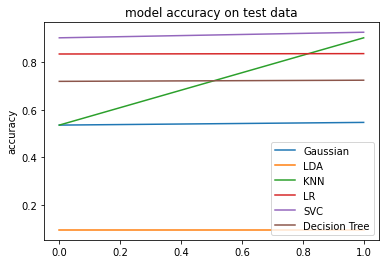

In [9]:
import matplotlib.pyplot as plt 

plt.plot([0.535541, 0.54685])
plt.plot([0.096122, 0.096122])
plt.plot([0.535541, 0.90145])
plt.plot([0.83360, 0.8352])
plt.plot([0.90145, 0.9248])
plt.plot([0.7189014, 0.72374])
plt.title('model accuracy on test data')
plt.ylabel('accuracy')
plt.legend(['Gaussian', 'LDA', 'KNN', 'LR', 'SVC', 'Decision Tree'], loc='lower right')
plt.show()

#### Question 18:

Most of our algorithms did not see a notable rise in accuracy after tuning. However, KNN raised from 53% to more than 90%. SVC is still our best performing tuned algorithm, therefore we will use it to make our predictions. 

#### Question 19 (optional):

#### Question 20:

We will use the SVC algorithm, since it was the algorithm with the highest accuracy on unseen data (test dataset)

In [29]:
#Define our model
svc_final = SVC(C = 5, degree = 2,  kernel = 'rbf', gamma="auto", random_state = 42)
mnist_28x28_train_scaled = np.reshape(mnist_28x28_train_scaled, (mnist_28x28_train_scaled.shape[0], -1))
svc_final.fit(mnist_28x28_train_scaled, mnist_28x28_labels)

SVC(C=5, degree=2, gamma='auto', random_state=42)

In [30]:
scaler_final = preprocessing.StandardScaler()
X_unknown_reshaped = np.reshape(mnist_unknown, (mnist_unknown.shape[0], -1))
scaler_final.fit(X_reshaped)

X_unknown_scaled = scaler.transform(X_unknown_reshaped)
final_predictions = svc_final.predict(X_unknown_scaled)
final_predictions

array([4, 3, 1, ..., 6, 8, 5])

#### Question 21:

In [31]:
acc_final = svc_final.score(X_test_28_reshaped, y_test_28)
print("Accuracy of test set")
print(acc_final)

Accuracy of test set
0.9975767366720517


The evolution of our models before and after hyper-parameter tuning were evaluated using the test datasets, since it gives us a good preview of generalization performance as well as a hint on how it might perform during training. Therefore, our current SVC model performs well with unseen data and hence it has a good generalization metric. 

#### Question 22:

In [32]:
svc_cm = confusion_matrix(y_test_28, svc_final.predict(X_test_28_reshaped) , labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(svc_cm)
print('\n')

[[121   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0   0   0]
 [  0   0 116   0   0   0   0   0   0   0]
 [  0   0   0 135   0   0   0   0   0   0]
 [  0   0   0   0 135   0   0   0   0   0]
 [  0   0   0   0   0 122   0   0   0   0]
 [  0   0   0   0   0   0 110   0   0   0]
 [  0   1   0   0   0   0   0 120   0   0]
 [  0   0   0   0   0   1   0   0 127   0]
 [  0   0   0   0   1   0   0   0   0 127]]




Since our model has a high accuracy score, we can see that most of our values are correctly classified, i.e. the values on the main diagonal. For each label, there are a few false positives and false negatives (on the top and bottom of main diagonal respectively) which represent the misclassifications of our model. 

#### Question 23:

In [33]:
# TODO Replace this with your own estimate of the accuracy
estimate_accuracy = np.array([acc_final - 0.05]) #Take 5% due to potential overfitting
# Reshape unknow prediction array
prediction = np.array(final_predictions)

result = np.append(estimate_accuracy, prediction)
# Upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("accuracy_estimate_and_predictions.txt", index=False, header=False)

Score: 35/44, acc between 92 and 94, estimated correctly

### 5 Conclusions

#### Question 24:

1. GaussianNB: This model is really easy to train and tune since it has no hyper parameters, however, it only works under the NB assumption and when data is normally distributed. 
2. Linear Discriminant Analysis: Again, a really easy to use model, but it does not work with non-linear relationships and hence it worked poorly with the image classification task.
3. KNN: Accuracy on test set was > 90%, which makes sense since KNN is able to map relationships between similar images due to the closeness of the coloured pixels.
4. SGDClassifier: It works fine for image classification problems, but its training procedure can get complex due to the availability of hyperparameters. 
5. Support Vector Machines: After the hyperparameter tuning its test accuracy significantly increase, which may suggest that it needs tuning to be successful with non-linear relationships such as this one. 
6. Decision Tree: Would not be my first choice with this kind of problem due to the large amount of features (pixels) and the small difference in some of them between different classes (due to grayscale). It is also complex to train and it is easily overfitted. 
